# Notebook for Dog Classifier

## Importing Libraries

In [37]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [38]:
#hide
from fastbook import *
from fastai.vision.widgets import *

## Add Azure Search Key

To be able to download images from bing search.

In [39]:
key = os.environ.get('AZURE_SEARCH_KEY', '<KEY>')

In [40]:
help(fastbook)

Help on package fastbook:

NAME
    fastbook

PACKAGE CONTENTS
    _nbdev

FUNCTIONS
    array(...)
        array(object, dtype=None, copy=True, order='K', subok=False, ndmin=0)
        
        Create an array.
        
        Parameters
        ----------
        object : array_like
            An array, any object exposing the array interface, an object whose
            __array__ method returns an array, or any (nested) sequence.
        dtype : data-type, optional
            The desired data-type for the array.  If not given, then the type will
            be determined as the minimum type required to hold the objects in the
            sequence.
        copy : bool, optional
            If true (default), then the object is copied.  Otherwise, a copy will
            only be made if __array__ returns a copy, if obj is a nested sequence,
            or if a copy is needed to satisfy any of the other requirements
            (`dtype`, `order`, etc.).
        order : {'K', 'A', 'C

In [41]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

In [42]:
results = search_images_bing(key, 'german shepherd dogs')
images = results.attrgot('content_url')
len(images)

150

In [43]:
images

(#150) ['https://www.pets4homes.co.uk/images/breeds/10/large/5f8a5db4ce053562ca46cfb48806087f.jpg','https://www.perropet.com/wp-content/uploads/2016/05/Buck_The_GSD.jpg','http://www.survivopedia.com/wp-content/uploads/2013/08/20110425_German_Shepherd_Dog_8473.jpg','https://www.pets4homes.co.uk/images/breeds/10/large/c231b08a94097d24fb0577b5bcff1d74.jpg','https://www.talenthounds.ca/wp-content/uploads/formidable/IMG_2413.jpg','https://sasscer.files.wordpress.com/2014/05/image33.jpg','https://thehappypuppysite.com/wp-content/uploads/2017/06/gsd2-751x1024.jpg','http://cdn.marketplace.akc.org/media/33179/1449694992_9579_9541.newpng.jpg','https://www.pets4homes.co.uk/images/articles/1963/large/the-personality-traits-of-the-german-shepherd-dog-53dfa8bc8d21e.jpg','http://3.bp.blogspot.com/-sZiCAlma2Bs/U0zOCze9L1I/AAAAAAAACCQ/MkH--rIK8Qw/s1600/German-Shepherd-Dog-cute-wallpapers.jpg'...]

In [45]:
dest = 'images/example.jpg'
download_url(images[1], dest)

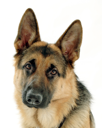

In [46]:
im = Image.open(dest)
im.to_thumb(128,128)

In [47]:
dog_types = ['german shepherd', 'black', 'labrador']
path = Path('dogs')


In [48]:
if not path.exists():
    path.mkdir()
    for t in dog_types:
        dest = (path/t)
        print(dest)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, '{} dog'.format(t))
        download_images(dest, urls=results.attrgot('content_url'))
    

In [49]:
files = get_image_files(path)
files


(#379) [Path('dogs/german shepherd/00000107.jpg'),Path('dogs/german shepherd/00000034.jpg'),Path('dogs/german shepherd/00000091.jpg'),Path('dogs/german shepherd/00000135.jpg'),Path('dogs/german shepherd/00000126.jpg'),Path('dogs/german shepherd/00000023.jpg'),Path('dogs/german shepherd/00000012.jpg'),Path('dogs/german shepherd/00000098.jpg'),Path('dogs/german shepherd/00000086.png'),Path('dogs/german shepherd/00000140.jpg')...]

In [50]:
##finding out the no. of failed images
corrupt = verify_images(files)
corrupt

(#0) []

In [51]:
##removing all the failed images using unlink
corrupt.map(Path.unlink);

## Converting Data to DataBlock objects

In [52]:
##
dogs = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=41),
        get_y=parent_label,
        item_tfms=Resize(128)
        )

In [53]:
dls = dogs.dataloaders(path)

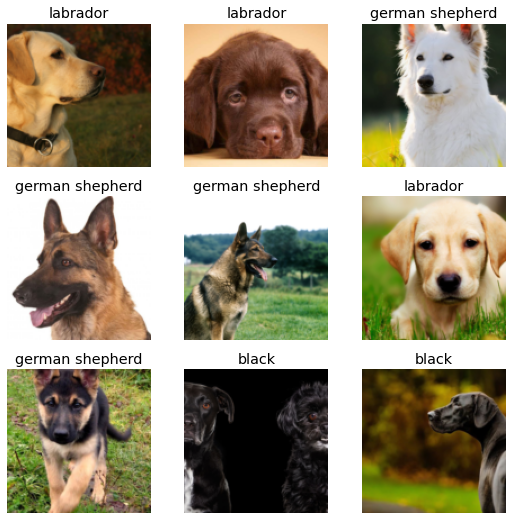

In [54]:
dls.valid.show_batch()

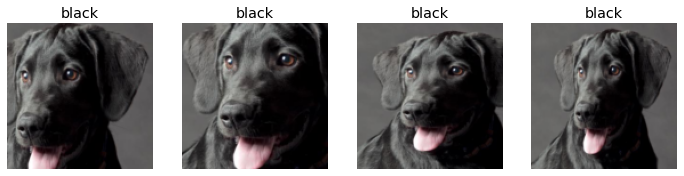

In [55]:
##adding item transformations
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Data Augmentation


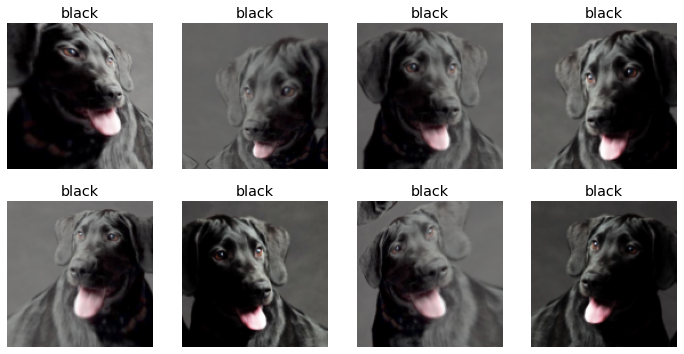

In [56]:
##adding item transformations
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training the Model

In [57]:
dogs = dogs.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
               batch_tfms=aug_transforms())

dls = dogs.dataloaders(path)

In [58]:
model = cnn_learner(dls, resnet18, metrics=error_rate)
model.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.693385,0.539964,0.240000,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.520164,0.300191,0.106667,00:04
1,0.453528,0.263201,0.120000,00:04
2,0.380826,0.212149,0.080000,00:04
3,0.351675,0.183465,0.053333,00:05


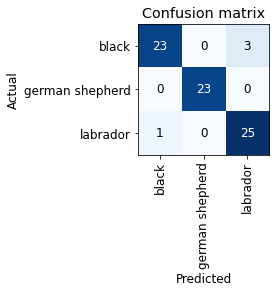

In [59]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

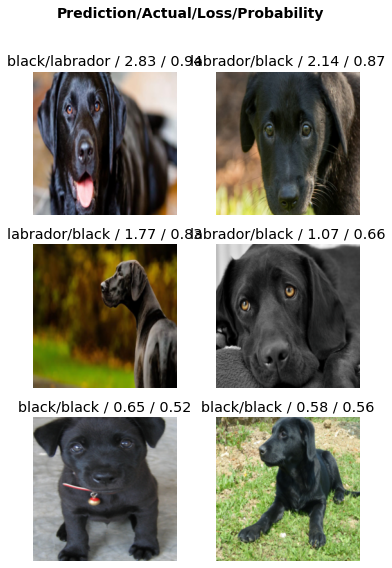

In [60]:
interp.plot_top_losses(6, nrows=3)

## Cleaning the Data

In [61]:
cleaner = ImageClassifierCleaner(model)
cleaner

In [62]:
for idx,cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), str(path/cat).split('.')[0] + "_fixed.jpg")

## Export the Model

In [63]:
model.export()

In [64]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Load the model

In [65]:
model_inf = load_learner(path/'export.pkl')

## Make Inferences from the loaded model

In [66]:
model_inf.predict('dogs/labrador/00000000.jpg')

('labrador', tensor(2), tensor([1.5323e-05, 8.7831e-06, 9.9998e-01]))

In [67]:
model_inf.dls.vocab

(#3) ['black','german shepherd','labrador']

## Add widgets to upload and classify images

In [68]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [69]:
VBox([widgets.Label('Select your dog!'),
      btn_upload, btn_run, out_pl, lbl_pred])